In [58]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm, truncnorm
from scipy.special import erf

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from main_code.utils.CosmoFunc import gaus
from main_code.utils.constants import SURVEY_VELDISP_LIMIT

# Calculate best-fit Gaussian from mock

In [ ]:
# Load mock data
df_mock = pd.read_csv("../../data/mocks/mock_galaxies/all_combined_mocks_smin_1_fp_fit_method_0.txt", delim_whitespace=True)

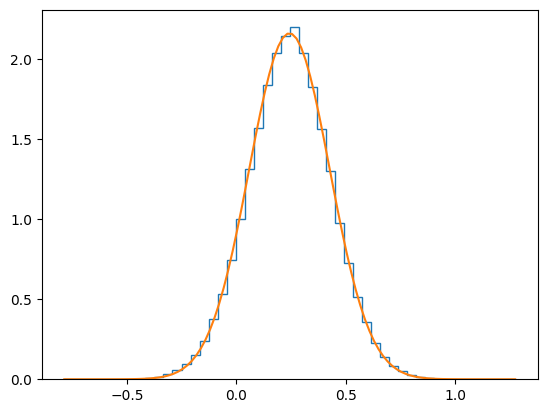

In [ ]:
mock_fits = {}

# Fit r with full Gaussian
xdata = df_mock["r"].to_numpy()

y, x_edges = np.histogram(xdata, bins=50, density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(xdata), np.std(xdata)])

print("Mu: ", popt[0])
print("Sigma: ", popt[1])
mock_fits["r"] = popt

x_trial = np.linspace(np.min(xdata), np.max(xdata), 100)
y_trial = gaus(x_trial, *popt)

plt.hist(xdata, bins=50, density=True, histtype="step")
plt.plot(x_trial, y_trial)
plt.show()

Mu:  3.193502104686715
Sigma:  0.23563446469549082


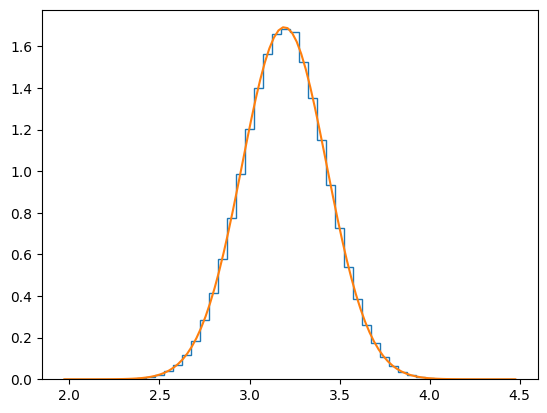

In [68]:
# Fit i with full Gaussian
xdata = df_mock["i"].to_numpy()

y, x_edges = np.histogram(xdata, bins=50, density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(xdata), np.std(xdata)])

print("Mu: ", popt[0])
print("Sigma: ", popt[1])
mock_fits["i"] = popt

x_trial = np.linspace(np.min(xdata), np.max(xdata), 100)
y_trial = gaus(x_trial, *popt)

plt.hist(xdata, bins=50, density=True, histtype="step")
plt.plot(x_trial, y_trial)
plt.show()

In [ ]:
# Create my own truncnorm
def cdf(x):
    return 0.5 * (1 + erf(x / np.sqrt(2)))

def norm_gauss(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

def trunc_gaus(x, mu, sigma, a, b):
    numerator = norm_gauss((x - mu) / sigma)
    denom_1 = cdf((b - mu) / sigma)
    denom_2 = cdf((a - mu) / sigma)

    output = (1 / sigma) * numerator / (denom_1 - denom_2)

    output[(x <= a) | (x >= b)] = 0

    return output


x = np.linspace(2., 4.5, 100)
y1 = trunc_gaus(x, popt[0], popt[1], 3, 4)
y2 = trunc_gaus(x, popt[0], popt[1], -np.inf, np.inf)

plt.plot(x, y1)
plt.plot(x, y2)

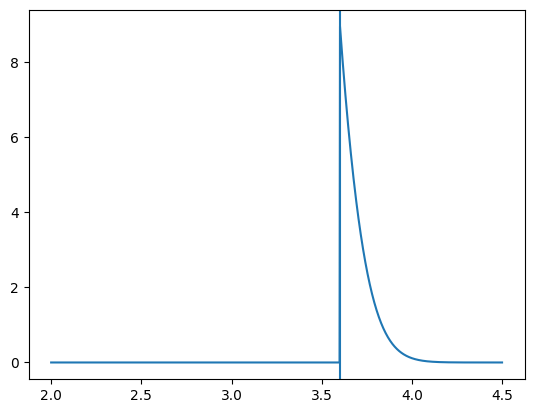

In [ ]:
# Use scipy stats truncnorm
x = np.linspace(2., 4.5, 1000)

mu = 3.1935021
sigma = 0.23563446
left_clip = 3.6
right_clip = np.inf
a, b = (left_clip - mu) / sigma, (np.inf - mu) / sigma
y = truncnorm.pdf(x, a, b, loc=mu, scale=sigma)

plt.plot(x, y)
plt.axvline(x=left_clip)

Mu:  2.284118904510861
Sigma:  0.1092384025324732


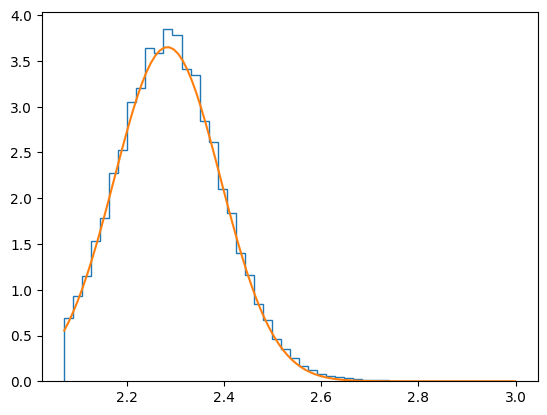

In [69]:
def left_truncnorm(x, mu, sigma):
    a = (SURVEY_VELDISP_LIMIT[1]["6dFGS"] - mu) / sigma
    return truncnorm.pdf(x, a, np.inf, loc=mu, scale=sigma)

# Fit s with truncated normal
xdata = df_mock["s"].to_numpy()
xdata = xdata[xdata < 3.0]

y, x_edges = np.histogram(xdata, bins=50, density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(left_truncnorm, x, y, p0=[np.mean(xdata), np.std(xdata)])

print("Mu: ", popt[0])
print("Sigma: ", popt[1])
mock_fits["s"] = popt

x_trial = np.linspace(np.min(xdata), np.max(xdata), 100)
y_trial = gaus(x_trial, *popt)

plt.hist(xdata, bins=50, density=True, histtype="step")
plt.plot(x_trial, y_trial)
plt.show()

In [70]:
mock_fits

{'r': array([0.24280286, 0.18434121]),
 'i': array([3.1935021 , 0.23563446]),
 's': array([2.2841189, 0.1092384])}

# Perform 1-sample K-S test

In [81]:
# Load data
df_data = pd.read_csv("../../data/foundation/fp_sample_final/smin_setting_1/fp_fit_method_0/all_combined.csv")

r_data = df_data["r"].to_numpy()
s_data = df_data["s"].to_numpy()
i_data = df_data["i"].to_numpy()

# r
print("r")
ks_statistic, p_value = stats.kstest(r_data, 'norm', args=(mock_fits["r"][0], mock_fits["r"][1]))
print(f"K-S Statistic: {ks_statistic}")
print(f"P-value: {p_value}")
print()

# s
print("s")
trunc_gaussian = truncnorm(a=(SURVEY_VELDISP_LIMIT[1]["6dFGS"] - mock_fits["s"][0]) / mock_fits["s"][1], b=np.inf, loc=mock_fits["s"][0], scale=mock_fits["s"][1])
ks_statistic, p_value = stats.kstest(s_data, trunc_gaussian.cdf)
print(f"K-S Statistic: {ks_statistic}")
print(f"P-value: {p_value}")
print()

# i
print("i")
ks_statistic, p_value = stats.kstest(i_data, 'norm', args=(mock_fits["i"][0], mock_fits["i"][1]))
print(f"K-S Statistic: {ks_statistic}")
print(f"P-value: {p_value}")
print()


r
K-S Statistic: 0.023871347056671877
P-value: 9.223493867105251e-07

s
K-S Statistic: 0.029795365389904155
P-value: 2.699717567662773e-10

i
K-S Statistic: 0.029048089111622932
P-value: 8.318810582796838e-10



# Sanity check

## K-S test of a known sample

In [153]:
x = np.random.normal(loc=0, scale=1, size=1000000)

ks_statistic, p_value = stats.kstest(x, 'norm', args=(0, 1))
print(f"K-S Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

K-S Statistic: 0.0005804338385502622
P-value: 0.8888805994046813


# Manual K-S test for $r$

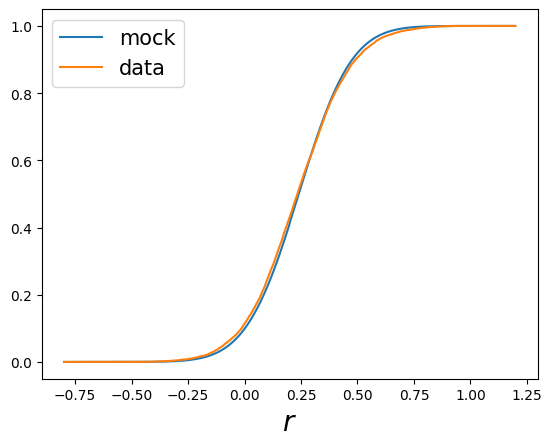

In [181]:
bins_ = np.linspace(-0.8, 1.2, 500)
delta_x = np.diff(bins_)[0]

# Create CDF for mock
r_mock = df_mock["r"].to_numpy()
y_mock, x_edges_mock = np.histogram(r_mock, bins=bins_, density=True)
x_mock = (x_edges_mock[1:] + x_edges_mock[:-1])/2
cdf_mock = np.cumsum(y_mock * delta_x)

# Create CDF for data
r_data = df_data["r"].to_numpy()
y_data, x_edges_data = np.histogram(r_data, bins=bins_, density=True)
x_data = (x_edges_data[1:] + x_edges_data[:-1])/2
cdf_data = np.cumsum(y_data * delta_x)

# Calculate K-S statistic
# ks_stat = np.max(np.absolute(np.cumsum(y_mock * delta_x) - np.cumsum(y_data * delta_x)))
# print("K-S statistic: ", ks_stat)
D_plus = np.arange(len(cdf_mock))

plt.plot(x_mock, cdf_mock, label="mock")
plt.plot(x_data, cdf_data, label="data")
plt.xlabel(r"$r$", fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [182]:
stats.kstest(r_data, r_mock)

KstestResult(statistic=0.02448967620835285, pvalue=4.3582519777451205e-07, statistic_location=0.1509968579512131, statistic_sign=1)